In [67]:
# Importing necessary libraries
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [63]:
file = pd.read_csv('./results/GRNA_2_2_2023_10_27_17_22_4.csv',  header = None)
file.columns = ['subject_id', 'trial', 'condition', 'resp', 'RT', 'corr']
full_values = file['condition'].value_counts()
print(file)
print(full_values)

     subject_id  trial  condition  resp        RT  corr
0             4      1          1    99  99.00000     0
1             4      2          2     1   0.71979     1
2             4      3          0     2   0.98040     1
3             4      4          1     2   0.55840     1
4             4      5          2     1   0.60024     1
..          ...    ...        ...   ...       ...   ...
187           4    188          0     2   0.41441     1
188           4    189          0     2   0.50323     1
189           4    190          2     1   0.50833     1
190           4    191          2     1   0.42424     1
191           4    192          2     1   0.48964     1

[192 rows x 6 columns]
2    96
0    64
1    32
Name: condition, dtype: int64


In [3]:
drop_idx = file[(file['condition'] == 2) | (file['corr'] == 0)].index
file = file.drop(drop_idx)
drop_values = file['condition'].value_counts()

mean = file['RT'].mean()
std_dev = file['RT'].std()

# Creating a boolean mask to identify non-outliers
non_outliers = (file['RT'] >= mean - 3*std_dev) & (file['RT'] <= mean + 3*std_dev)

# Using the boolean mask to filter the dataframe
file = file[non_outliers]

In [45]:
file.head()

,subject_id,trial,condition,resp,RT,corr
0,4,1,1,99,99.00000,0
1,4,2,2,1,0.71979,1
2,4,3,0,2,0.98040,1
3,4,4,1,2,0.55840,1
4,4,5,2,1,0.60024,1


Text(0, 0.5, 'RT')

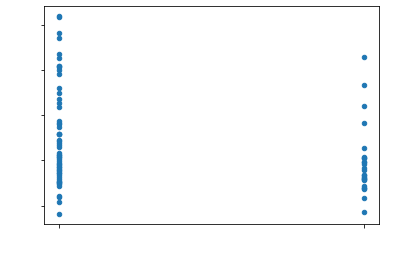

In [5]:
file.plot.scatter(x = 'condition', y = 'RT')
plt.xlabel('condition', color = 'white')
plt.xticks([0, 1], ['incongruent', 'congruent'], color = 'white')
plt.yticks(color = 'white')
plt.ylabel('RT', color = 'white')

In [48]:
# removing outlier function
def remove_outliers(data):
    mean = data['RT'].mean()
    std_dev = data['RT'].std()
    
    # Creating a boolean mask to identify non-outliers
    non_outliers = (data['RT'] >= mean - 3*std_dev) & (data['RT'] <= mean + 3*std_dev)
    
    # Using the boolean mask to filter the group
    return data[non_outliers]

# removing missing value
def remove_missing(data):
    drop_idx = data[data['resp'] == 99].index
    data = data.drop(drop_idx)
    return data

# remove same or incorrect trials
def data_prepro(data):
    drop_idx = data[(data['condition'] == 2) | (data['corr'] == 0)].index
    data = data.drop(drop_idx)
    return data

In [53]:
file = remove_missing(file)
print(file)

     subject_id  trial  condition  resp       RT  corr
1             4      2          2     1  0.71979     1
2             4      3          0     2  0.98040     1
3             4      4          1     2  0.55840     1
4             4      5          2     1  0.60024     1
5             4      6          0     2  0.58528     1
..          ...    ...        ...   ...      ...   ...
187           4    188          0     2  0.41441     1
188           4    189          0     2  0.50323     1
189           4    190          2     1  0.50833     1
190           4    191          2     1  0.42424     1
191           4    192          2     1  0.48964     1

[181 rows x 6 columns]


In [54]:
# Creating a  DataFrame
path = './results/'
file_list = os.listdir(path)
file_list_py = [file for file in file_list if file.endswith('.csv')]

df = pd.DataFrame(columns=['condition', 'RT'])
missing_array = []

# for every csvs in exp results folder
for i in file_list_py:
    data = pd.read_csv(path + i, header = None)
    subjdf = pd.DataFrame(data)
    subjdf.columns = ['subject_id', 'trial', 'condition', 'resp', 'RT', 'corr']
    full_values = subjdf['condition'].value_counts()
    
    # data pre-processing
    subjdf = remove_missing(subjdf)
    
    subjdf = remove_outliers(subjdf)
    
    subjdf = data_prepro(subjdf)
    
    missing_values = full_values - subjdf['condition'].value_counts()
    missing_array.append(missing_values[0])
    missing_array.append(missing_values[1])
    
    # append subject data to main data
    conditions = subjdf['condition'].unique()
    subject_id = str(subjdf['subject_id'].unique()[0])
    for condition in conditions:
         # Filtering the DataFrame based on the condition
        condition_df = subjdf[subjdf['condition'] == condition]
    
        # Calculating the mean
        cond_RT = condition_df['RT'].mean()
    
        # Appending the mean value to the empty DataFrame
        df = df.append({'subject_id': subject_id, 'condition': condition, 'RT': cond_RT}, ignore_index=True)

df['missing_values'] = missing_array
df['missing_values'] = df['missing_values'].astype('category')
print(df)

   condition        RT subject_id missing_values
0          1  0.581273          3            3.0
1          0  0.589768          3            0.0
2          0  0.435825         11            5.0
3          1  0.435965         11            1.0
4          0  0.537559         13            2.0
5          1  0.504904         13            3.0
6          1  0.610628         15            2.0
7          0  0.656181         15            1.0
8          0  0.501964         17            4.0
9          1  0.551630         17            1.0
10         0  0.547451          1            2.0
11         1  0.526074          1            2.0
12         0  0.452668          5            0.0
13         1  0.460098          5            4.0
14         1  0.526039          7            4.0
15         0  0.535388          7            2.0
16         0  0.495949          9            1.0
17         1  0.476212          9            2.0
18         0  0.540587          2            2.0
19         1  0.5124

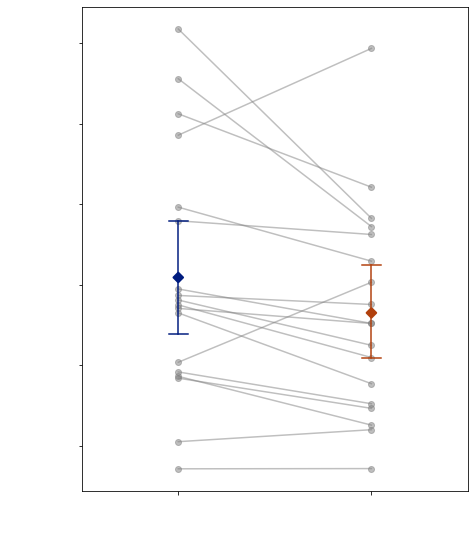

In [92]:
# Calculate group means and the standard error of the mean (SEM)
group_stats = df.groupby('condition')['RT'].agg(['mean', 'sem']).reset_index()

# Start the plot
plt.figure(figsize=(7, 8))

# Plot individual subject lines
for subject in df['subject_id'].unique():
    subject_data = df[df['subject_id'] == subject]
    plt.plot(subject_data['condition'], subject_data['RT'], marker='o', color='grey', alpha=0.5)

# Overlay the group means with error bars
sns.pointplot(data=df, x='condition', y='RT', capsize=0.1, join=False, palette="dark", markers='D', errwidth=1.5)

# Improve the aesthetics and layout
plt.rc('axes', labelsize= 15)
plt.xlabel('Condition', color = 'white')
plt.xticks([0, 1], ['incongruent', 'congruent'], color = 'white')
plt.ylabel('Reaction Time(sec)', color = 'white')
plt.yticks(color = 'white')
plt.tight_layout()

# Show the plot
plt.show()

In [84]:
model = smf.mixedlm('RT ~ condition', df, groups = df['subject_id'])
result = model.fit()
print(result.summary())

          Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  RT     
No. Observations:   36       Method:              REML   
No. Groups:         18       Scale:               0.0008 
Min. group size:    2        Log-Likelihood:      48.8947
Max. group size:    2        Converged:           Yes    
Mean group size:    2.0                                  
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.555    0.017 33.021 0.000  0.522  0.588
condition[T.1] -0.022    0.010 -2.287 0.022 -0.041 -0.003
Group Var       0.004    0.078                           



C:\Users\user\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


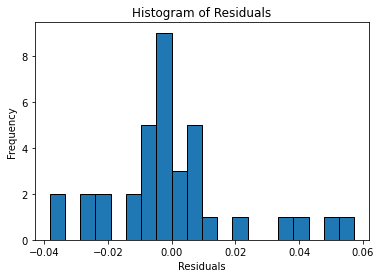

Shapiro-Wilk test statistic: 0.9125809669494629, p-value: 0.00767223397269845


In [85]:
residuals = result.resid
plt.hist(residuals, bins=20, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()
shapiro_test = stats.shapiro(residuals)
print(f"Shapiro-Wilk test statistic: {shapiro_test[0]}, p-value: {shapiro_test[1]}")

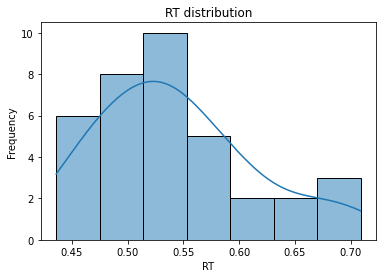

In [86]:
sns.histplot(df['RT'], kde=True)
plt.title('RT distribution')
plt.xlabel('RT')
plt.ylabel('Frequency')
plt.show()

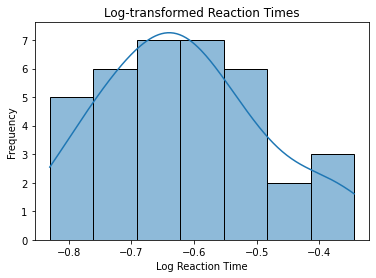

In [87]:
df['log_RT'] = np.log(df['RT'])
sns.histplot(df['log_RT'], kde=True)
plt.title('Log-transformed Reaction Times')
plt.xlabel('Log Reaction Time')
plt.ylabel('Frequency')
plt.show()

In [88]:
md = smf.mixedlm("log_RT ~ condition", df, groups=df["subject_id"])
mdf = md.fit()
print(mdf.summary())

          Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  log_RT 
No. Observations:    36       Method:              REML   
No. Groups:          18       Scale:               0.0022 
Min. group size:     2        Log-Likelihood:      30.5128
Max. group size:     2        Converged:           Yes    
Mean group size:     2.0                                  
----------------------------------------------------------
               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept      -0.598    0.030 -19.853 0.000 -0.657 -0.539
condition[T.1] -0.038    0.016  -2.454 0.014 -0.069 -0.008
Group Var       0.014    0.157                            



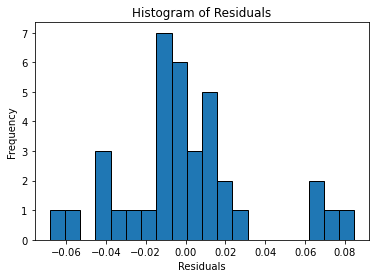

Shapiro-Wilk test statistic: 0.9377485513687134, p-value: 0.04324832931160927


In [89]:
residuals = mdf.resid
plt.hist(residuals, bins=20, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()
shapiro_test = stats.shapiro(residuals)
print(f"Shapiro-Wilk test statistic: {shapiro_test[0]}, p-value: {shapiro_test[1]}")

In [113]:
df.to_csv('test.csv', index=False)